In [4]:
import pandas as pd
import IPython.display as ipd
import librosa
import soundfile as sf
import seaborn as sns
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

#Keras Imports
from tensorflow.keras import models, layers, optimizers, initializers
from keras.applications import ResNet50, VGG16

from skimage.transform import resize

from PIL import Image

from distributed import Client

import dask.dataframe as dd
import dask.array as da

import pandas as pd
import dask_ml
from dask_ml.preprocessing import DummyEncoder
import glob

import boto3
from dask import delayed

import soundfile as sf
from dask_ml.wrappers import Incremental

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

from tensorflow.keras.optimizers import Adam, SGD

from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy, BinaryCrossentropy

from datetime import datetime
from datetime import timezone
import pickle

from tensorflow.keras.experimental import LinearModel

from dask.diagnostics import ProgressBar
import pandas as pd

In [5]:
#Load the progress bar
pbar = ProgressBar()
pbar.register()

### Read Helper CSV from the s3 bucket

In [6]:
data_tp = dd.read_csv('s3://rainforest-connection/train_tp.csv')
data_tp = data_tp.repartition(20)

### Mount the bucket locally 

Librosa does not have a built in boto3 reader which makes reading from the s3 bucket challenging. Instead of reading from the s3 bucket directly, the s3 bucket is mounted locally which will be read by a single machine

In [16]:
!s3fs rainforest-connection rainforest

### Load Audio Data 

#### Train Data

In [ ]:
def load_audio(data):
    """
    Convert audio into numpy. Return the numpy, sampling rate and species_id
    """
    try:        
        x , sr = librosa.load(f'rainforest/train/{data.recording_id}.flac')
        return x, sr, data.species_id
    except:
        return None
    
def save_parquet(data, filename):
    """
    Save the parquet to the s3 bucket
    """
    
    start = datetime.now()
    print(f'starting {start}')
    data.to_parquet(f's3://rainforest-connection/{filename}.pqt',
                    engine='pyarrow')
    end = datetime.now()
    print(f'Elapsed Time {end - start}')

audio_files = (data_tp
               .apply(load_audio, 
                      meta=(None, 'object'),
                      axis=1)
              )

data_tp['audio'] = audio_files.apply(lambda x: x[0], meta=(None, 'object'))
data_tp['sr'] = audio_files.apply(lambda x: x[1], meta=(None, 'object'))
save_parquet(data_tp,'test')

#### Test Data

In [ ]:
#instantiate boto3 client
s3 = boto3.client('s3')

#read test audio files
files = glob.glob('rainforest/test/*')
audio_files = []

for idx, file in enumerate(files): 
    start = datetime.now()
    #load audio file and convert to numpy array
    wav, sr = librosa.load(file, sr=None)
    audio_files.append[[wav,sr]]
    
with open('train_output.pickle', 'wb') as handle:
    pickle.dump(audio_files, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
#upload to s3 bucket
s3.upload_file(f'test_processed_audio.pkl', 'rainforest-connection', 
               f'test_processed_audio.pkl')

### Instatitate Dask Cluster

In [40]:
client = Client('54.172.4.226:8786')
client

/opt/conda/lib/python3.8/site-packages/distributed/client.py:1129: VersionMismatchWarning: Mismatched versions found

+---------+---------------+---------------+---------------+
| Package | client        | scheduler     | workers       |
+---------+---------------+---------------+---------------+
| dask    | 2020.12.0     | 2.30.0        | 2.30.0        |
| numpy   | 1.19.5        | 1.19.1        | 1.19.1        |
| python  | 3.8.2.final.0 | 3.8.5.final.0 | 3.8.5.final.0 |
+---------+---------------+---------------+---------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))
/opt/conda/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36627 instead
  warnings.warn(
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


Client Scheduler: tcp://127.0.0.1:42687 Dashboard: http://127.0.0.1:36627/status,Cluster Workers: 4 Cores: 16 Memory: 67.42 GB


### Load numpy audio files

In [20]:
#Load the numpy audio file from s3
processed_audio = dd.read_parquet(
    's3://rainforest-connection/processsed_audio.pqt',
    storage_options={"use_listings_cache": False},
    engine='pyarrow')

### Generate Mels-pectrogram

#### Train Data

In [44]:
fft = 2048 # fast fourier transform window
hop = 512 # hop length

# Less rounding errors this way
sr = 48000 # sampling rate
length = 10 * sr
fp_train_len = 500
ctr = 0


def convert_melspec(data):    
    """
    Generate the mel-spectrogram from  the numpy audio representation.
    """
    x = data.audio
    sr = data.sr
    
    #Get the minimum and maximum timeframe for the specie
    t_min = float(data.t_min) * sr
    t_max = float(data.f_min) * sr
    
    #Get the minimum amd maximum frequency for the specie
    fmin = data.f_min
    fmax = data.f_max
    
    #Standardize the shape of the mel-spectrogram
    center = np.round((t_min + t_max) / 2)
    beginning = center - length / 2
    
    if beginning < 0:
            beginning = 0
    ending = beginning + length

    if ending > len(x):
        ending = len(x)
        beginning = ending - length
        
    #slice the corresponding audio file to retrieve the specie part
    slice_img = x[int(beginning):int(ending)]
    
    #generate mel-spectrogram
    xs = librosa.feature.melspectrogram(slice_img, n_fft=fft, hop_length=hop, 
                                    sr=sr, fmin=fmin, fmax=fmax, power=1.5)
    
    #convert amplitude to decibel
    xdb = librosa.amplitude_to_db(abs(xs))
    
    
    plt.ioff()
    
    #generate image
    mel = librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.axis('off')
    
    #remove margins
    plt.margins(0,0)
    plt.tight_layout()
    
    fig = plt.gcf()
    canvas = FigureCanvas(fig)
    canvas.draw()       # draw the canvas, cache the renderer

    #generate the image array instead of saving and displaying the image
    img_arr = np.frombuffer (canvas.tostring_rgb(), dtype='uint8')
    img_arr = img_arr.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    #one hot encode the specie
    specie = np.zeros(24)
    specie[data.species_id] = 1         
    
    return img_arr, specie

start = datetime.now()
melspec_temp = (
                processed_audio
                .apply(convert_melspec, meta=(None, 'object'),
                       axis=1)
               )
#separate the specie and the mel-spectrogram
melspec_temp = melspec_temp.explode().to_dask_array()

data = melspec_temp.compute()

#x value corresponds to the mel-spectrogram while y corresponds to the target
x = data[::2]
y = data[1::2]
end = datetime.now()
print(f'Elapsed Time {end - start}')

Elapsed Time 0:41:52.335278


#### Test Data

In [ ]:
predict_arr = []
images = []
file_names = []

with open('train_output.pickle', 'rb') as file:
    audio = pickle.load(file)

for idx, wav in enumerate(audio): 
    """
    Iterate through audio file in the pickle
    """
    
    #Start splicing from 0 seconds until 10 seconds
    t_lower = 0.0
    t_upper = 10.0
    t_min = 0
    t_max = 0 

    img_pred = []
    
    length = 10 * sr
    
    while t_upper <= (len(wav)/sr):
        t_min = t_lower * sr
        t_max = t_upper * sr         
        
        #standardize the shape of the mel-spectrogram
        center = np.round((t_min + t_max) / 2)
        beginning = center - length / 2
        if beginning < 0:
            beginning = 0

        ending = beginning + length
        if ending > len(wav):
            ending = len(wav)
            beginning = ending - length

        #splice the audio file
        sliced = wav[int(beginning):int(ending)]
                
        #Generate mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(sliced, sr=sr)
        
        #convert amplitude to decibel
        xdb = librosa.amplitude_to_db(abs(mel_spec))
        
        #dispaly mel-spectrogram
        librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
        
        plt.axis('off');
        fig = plt.gcf()
        canvas = FigureCanvas(fig)
        canvas.draw()
        
        #get the numpy value instead of displaying
        img_arr = np.frombuffer (canvas.tostring_rgb(), dtype='uint8')
        img_arr = img_arr.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        
        img_pred.append(img_arr)
        t_lower = t_lower + 5
        t_upper = t_upper + 5
        
        #clear the figure to incease code efficiency
        plt.clf() 
    images.append(img_pred)

### Save to pickle

In [ ]:
with open('output.pickle', 'wb') as handle:
    pickle.dump(np.stack([x,y]), handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('train_melspec.pickle', 'wb') as handle:
    pickle.dump(images), handle, protocol=pickle.HIGHEST_PROTOCOL)

### Check mel-spectogram matrix

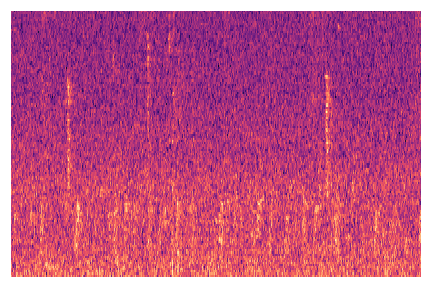

In [43]:
Image.fromarray(x[0], 'RGB')